(8693, 14) (4277, 13)


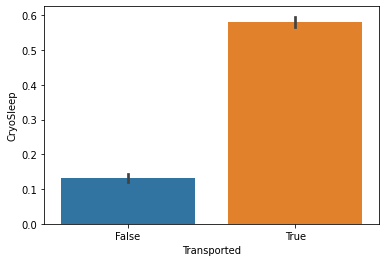

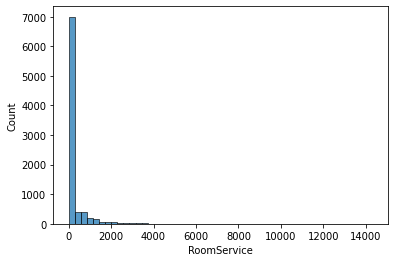

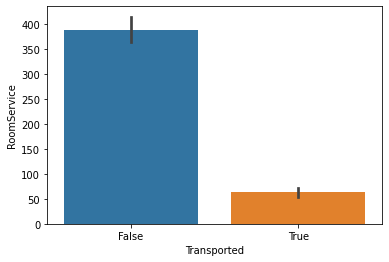

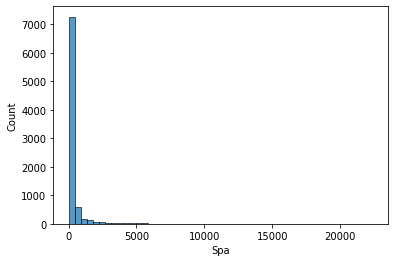

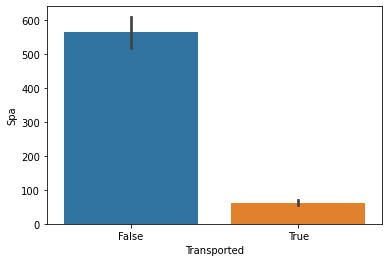

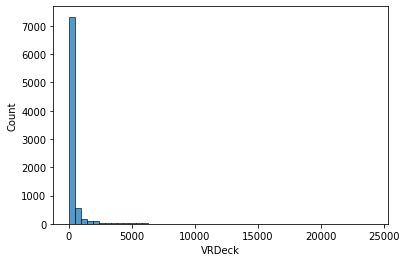

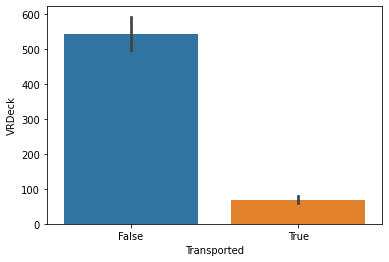

categorical features:  ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side'] numerical features:  ['Spa', 'VRDeck', 'RoomService', 'ShoppingMall', 'FoodCourt', 'Age']
(8258, 12) (435, 12) (8258, 1) (4277, 12)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8258 entries, 4691 to 4547
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8068 non-null   object 
 1   CryoSleep     8054 non-null   object 
 2   Destination   8085 non-null   object 
 3   Age           8087 non-null   float64
 4   VIP           8070 non-null   object 
 5   RoomService   8090 non-null   float64
 6   FoodCourt     8084 non-null   float64
 7   ShoppingMall  8058 non-null   float64
 8   Spa           8080 non-null   float64
 9   VRDeck        8077 non-null   float64
 10  Deck          8068 non-null   object 
 11  Side          8068 non-null   object 
dtypes: float64(6), object(6)
memory usage: 838.7+ KB
Missing value

In [82]:
# 0. Load libraries #

import numpy as np
import pandas as pd
import os, time, warnings
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 20)
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.expand_frame_repr', False)
warnings.filterwarnings('ignore')

def draw_histograms(df, variables, n_rows, n_cols):
    # stolen from https://stackoverflow.com/questions/29530355/plotting-multiple-histograms-in-grid
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  
    plt.show()


def fillna_mp_i1(df_train, df_test, df_pred, num_features, cat_features, num_fill='median', cat_fill='mode'):
    """This function speeds up filling missing values for 3 main datasets using different imputation methods.
    Later may replace it with some subclass.
    Example: fillna_mp_i1(X_train, X_test, X_pred, num_cols, cat_cols)"""
    # set df_pred to None if it does not exist
    if not ((cat_fill=='mode') and (num_fill=='median')):
        print ('Imputation method not Implemented yet!')
        return None
    
    df_train[num_features] = df_train[num_features].fillna(value=df_train[num_features].median())
    df_test[num_features] = df_test[num_features].fillna(value=df_train[num_features].median())
    df_train[cat_features] = df_train[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
    df_test[cat_features] = df_test[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
    if (df_pred is not None):
        df_pred[num_features] = df_pred[num_features].fillna(value=df_train[num_features].median())
        df_pred[cat_features] = df_pred[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
    df_train[num_features+cat_features].count
    
    all_good = (
    (np.prod(df_train[num_features+cat_features].shape)==df_train[num_features+cat_features].count().sum()) and 
    (np.prod(df_test[num_features+cat_features].shape) == df_test[num_features+cat_features].count().sum()) and 
    (np.prod(df_pred[num_features+cat_features].shape) == df_pred[num_features+cat_features].count().sum()))
    if (all_good):
        print('Missing values imputed successfully')
    else:
        print('There are still some missing values...')
    
def add_misDummy_mp_i1(df_train, df_test, df_pred, features):
    """This function creates new dummy columns for missing features.
    Example: add_misDummy_mp_i1(X_train, X_test, X_pred, ['Age'])"""
    # set df_pred to None if it does not exist
    for feature_name in features:
        misColName = 'mis'+feature_name
        df_train.loc[df_train[feature_name].isnull(), misColName]=1
        df_train.loc[df_train[feature_name].notnull(), misColName]=0
        df_test.loc[df_test[feature_name].isnull(), misColName]=1
        df_test.loc[df_test[feature_name].notnull(), misColName]=0
        if (df_pred is not None):
            df_pred.loc[df_pred[feature_name].isnull(), misColName]=1
            df_pred.loc[df_pred[feature_name].notnull(), misColName]=0
   

def discretize_mp_i1(df_train, df_test, df_pred, feature, ntiles, delete_feature=False):
    """This function divides a continuous feature into quantile groups.
    Example: discretize_mp_i1(X_train, X_test, X_pred, 'Age', 15)"""
    # set df_pred to None if it does not exist
    _,bin = pd.qcut(df_train[feature], ntiles, retbins = True, labels = False, duplicates = 'drop')
    df_train[feature+'Ntile'] = pd.cut(df_train[feature], labels=False, duplicates = 'drop', bins = bin ,include_lowest = True)
    df_test[feature+'Ntile'] = pd.cut(df_test[feature], labels=False, duplicates = 'drop', bins = bin ,include_lowest = True)
    if (df_pred is not None):
        df_pred[feature+'Ntile'] = pd.cut(df_pred[feature], labels=False, duplicates = 'drop', bins = bin ,include_lowest = True)
    if (delete_feature==True):
        df_train.drop(columns=[feature], inplace=True)
        df_test.drop(columns=[feature], inplace=True)
        df_pred.drop(columns=[feature], inplace=True)
    print('Discretized ',feature, ' into ', len(bin)-1, ' bins')


def log_transformer_mp_i1(df_train, df_test, df_pred, feature_subset=False, min_skew=3):
    """This function divides a continuous feature into quantile groups.
    Example: log_transformer_mp_i1(X_train, X_test, X_pred, feature_subset=num_cols)"""
    # set df_pred to None if it does not exist
    if (feature_subset==False):
        features_totransform = df_train.columns
    else:
        features_totransform = feature_subset.copy()
    skewed_vars = list(df_train.skew()[abs(df_train.skew())>min_skew].index)
    for col in list(set(skewed_vars)&set(features_totransform)):
        df_train[col] = np.log1p(df_train[col])
        df_test[col] = np.log1p(df_test[col])
        if (df_pred is not None):
            df_pred[col] = np.log1p(df_pred[col])
    print('Skewed columns log-transformed: ', list(set(skewed_vars)&set(features_totransform)))
    
    
# 1. Load data #

time0 = time.time()

path = '../input/spaceship-titanic/train.csv'
df = pd.read_csv(path) 

#df.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'],inplace=True)
pred=pd.read_csv('../input/spaceship-titanic/test.csv')
pred0 = pred.copy()
#pred.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'],inplace=True)

print(df.shape, pred.shape)
df.head()

# 2. pEDA #
df[['Deck', 'Room', 'Side']] = df['Cabin'].str.split('/', 2, expand=True)
pred[['Deck', 'Room', 'Side']] = pred['Cabin'].str.split('/', 2, expand=True)
df.drop(columns = ['PassengerId', 'Cabin', 'Room', 'Name'], inplace = True)
pred.drop(columns = ['PassengerId', 'Cabin', 'Room', 'Name'], inplace = True)
df

sns.barplot(x='Transported', y='CryoSleep', data=df)
plt.show()
sns.histplot(x='RoomService', data=df, bins=50)
plt.show()
sns.barplot(x='Transported', y='RoomService', data=df)
plt.show()
sns.histplot(x='Spa', data=df, bins=50)
plt.show()
sns.barplot(x='Transported', y='Spa', data=df)
plt.show()
sns.histplot(x='VRDeck', data=df, bins=50)
plt.show()
sns.barplot(x='Transported', y='VRDeck', data=df)
plt.show()

# 3. Train-test split #

train_y = df[['Transported']]
train_x = df.drop(columns = ['Transported'])
X_pred = pred.copy()

cat_cols = [col for col in train_x.columns if train_x[col].nunique() in range(2,10)]
num_cols = list(set(train_x.columns)-set(cat_cols))

print('categorical features: ', cat_cols, 'numerical features: ', num_cols)

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.05, random_state=8)
print(X_train.shape, X_test.shape, y_train.shape, X_pred.shape)

X_train.info()

# 4. Missing values #

add_misDummy_mp_i1(X_train, X_test, X_pred, ['Age', 'HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'RoomService',
'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Deck', 'Side'])
fillna_mp_i1(X_train, X_test, X_pred, num_cols, cat_cols)
X_train.info()

# 5. Feature engineering #

# add useful variables:


discretize_mp_i1(X_train, X_test, X_pred, 'Age', 10)
cat_cols.extend(['AgeNtile', 'ZeroRoomService', 'ZeroSpa', 'ZeroVRDeck',
                'misAge', 'misHomePlanet', 'misCryoSleep', 'misDestination', 'misVIP', 'misRoomService',
                'misFoodCourt', 'misShoppingMall', 'misSpa', 'misVRDeck', 'misDeck', 'misSide'])

X_train.describe()
X_train[:5]

log_transformer_mp_i1(X_train, X_test, X_pred, feature_subset=num_cols)

feature_transformer = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore"), cat_cols),
    ])

X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
X_pred = pd.DataFrame(feature_transformer.transform(X_pred), columns=feature_transformer.get_feature_names_out())

fewfeatures = []

print(X_train.shape)

# 6. Fit models #

lr = LogisticRegression()
param_grid = {'C':[0.03, 0.1, 0.3, 1]}
lrm = GridSearchCV(lr, param_grid, cv=8)
lrm.fit(X_train, y_train)
print('Logistic ', lrm.best_params_, accuracy_score(y_train, lrm.predict(X_train)))

time1 = time.time()
svm = SVC()
param_grid = {'C':[1, 2, 5]}
svmm = GridSearchCV(svm, param_grid, cv=2)
svmm.fit(X_train, y_train)
print('SVM ', svmm.best_params_, accuracy_score(y_train, svmm.predict(X_train)), time.time()-time1)

knn = KNeighborsClassifier()
param_grid = dict(n_neighbors=range(5, 36, 5))
knnm = GridSearchCV(knn, param_grid, cv=2)
knnm.fit(X_train, y_train)
print('KNN ', knnm.best_params_, accuracy_score(y_train, knnm.predict(X_train)))

time1 = time.time()
rf = RandomForestClassifier()
param_grid = {'n_estimators':[100], 'max_depth':[4,6,8,10], 'max_features':[6,7,8]}
rfm = GridSearchCV(rf, param_grid, cv=2)
rfm.fit(X_train, y_train)
print('RF ', rfm.best_params_, accuracy_score(y_train, rfm.predict(X_train)), time.time()-time1)

time1 = time.time()
xgb = XGBClassifier(tree_method='gpu_hist', gpu_id=0)
# use 'gpu_hist' for more than 10,000 examples.
param_grid = {'n_estimators':[100,200], 'max_depth':[2,3,4,5], 'eta':[0.04, 0.06, 0.08, 0.1], 
              'subsample':[0.6],'colsample_bytree':[0.6]}
#'subsample':[0.4, 0.6],'colsample_bytree':[0.6, 0.8]
xgbm = GridSearchCV(xgb, param_grid, cv=2)
xgbm.fit(X_train, y_train)
print('XGB ', xgbm.best_params_, accuracy_score(y_train, xgbm.predict(X_train)), time.time()-time1)

# 7. accuracy #

print('Out of Sample:')
print('Logistic ', accuracy_score(y_test, lrm.predict(X_test)))
print('SVM ', accuracy_score(y_test, svmm.predict(X_test)))
print('KNN ', accuracy_score(y_test, knnm.predict(X_test)))
print('RF ', accuracy_score(y_test, rfm.predict(X_test)))
print('XGB ', accuracy_score(y_test, xgbm.predict(X_test)))
print('Total time ', time.time()-time0)

# VotingClassifier:

estimator = []
#estimator.append(('LR', LogisticRegression(C=0.1)))
estimator.append(('SVM', SVC(C=1, probability = True)))
#estimator.append(('KNN', KNeighborsClassifier(n_neighbors=5)))
estimator.append(('RF', RandomForestClassifier(max_depth=8, max_features=7, n_estimators=100)))
estimator.append(('XGB', XGBClassifier(tree_method = 'gpu_hist', gpu_id=0,
                                       eta=0.05, max_depth=5, n_estimators=200, 
                                       subsample=0.6, colsample_bytree=0.6)))
vot_soft = VotingClassifier(estimators = estimator, voting ='soft')
vot_soft.fit(X_train, y_train)
print('VotingClassifier5 ', accuracy_score(y_train, vot_soft.predict(X_train)))
print('VotingClassifier5 ', accuracy_score(y_test, vot_soft.predict(X_test)))

In [71]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8258 entries, 0 to 8257
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   num__Spa                        8258 non-null   float64
 1   num__VRDeck                     8258 non-null   float64
 2   num__RoomService                8258 non-null   float64
 3   num__ShoppingMall               8258 non-null   float64
 4   num__Age2                       8258 non-null   float64
 5   num__FoodCourt                  8258 non-null   float64
 6   num__Age                        8258 non-null   float64
 7   cat__HomePlanet_Earth           8258 non-null   float64
 8   cat__HomePlanet_Europa          8258 non-null   float64
 9   cat__HomePlanet_Mars            8258 non-null   float64
 10  cat__CryoSleep_False            8258 non-null   float64
 11  cat__CryoSleep_True             8258 non-null   float64
 12  cat__Destination_55 Cancri e    82

In [83]:
# 8. feature importance #

results = permutation_importance(xgbm, X_test, y_test, scoring='accuracy', n_jobs=-1)
fi_lr = pd.DataFrame({'col':X_test.columns, 'FI':results.importances_mean})
fi_lr.sort_values('FI', ascending = False)[0:30]

,col,FI
0,num__Spa,6.206897e-02
9,cat__CryoSleep_False,5.793103e-02
1,num__VRDeck,3.172414e-02
4,num__FoodCourt,1.195402e-02
2,num__RoomService,1.149425e-02
20,cat__Deck_E,9.195402e-03
10,cat__CryoSleep_True,8.735632e-03
40,cat__ZeroVRDeck_0.0,7.816092e-03
38,cat__ZeroSpa_0.0,6.896552e-03
3,num__ShoppingMall,4.597701e-03


In [84]:
fi_lr.sort_values('FI', ascending = False)[31:]


,col,FI
50,cat__misVIP_0.0,0.000000
48,cat__misDestination_0.0,0.000000
59,cat__misSpa_1.0,0.000000
51,cat__misVIP_1.0,0.000000
54,cat__misFoodCourt_0.0,0.000000
55,cat__misFoodCourt_1.0,0.000000
57,cat__misShoppingMall_1.0,0.000000
58,cat__misSpa_0.0,0.000000
45,cat__misHomePlanet_1.0,0.000000
60,cat__misVRDeck_0.0,0.000000


In [41]:
# 9. predictions #

submission_df_vc = pd.DataFrame({'PassengerId': pred0.PassengerId, 'Transported': vot_soft.predict(X_pred)}, columns=['PassengerId', 'Transported'])
submission_df_svm = pd.DataFrame({'PassengerId': pred0.PassengerId, 'Transported': svmm.predict(X_pred)}, columns=['PassengerId', 'Transported'])
submission_df_rf = pd.DataFrame({'PassengerId': pred0.PassengerId, 'Transported': rfm.predict(X_pred)}, columns=['PassengerId', 'Transported'])
submission_df_bt = pd.DataFrame({'PassengerId': pred0.PassengerId, 'Transported': xgbm.predict(X_pred)}, columns=['PassengerId', 'Transported'])

submission_df_vc.to_csv('KP11_vc.csv',index=False)
submission_df_svm.to_csv('KP11_svm.csv',index=False)
submission_df_rf.to_csv('KP11_rf.csv',index=False)
submission_df_bt.to_csv('KP11_bt.csv',index=False)

os.chdir(r'/kaggle/working')

from IPython.display import FileLink
FileLink(r'KP11_vc.csv')

/kaggle/working/KP11_vc.csv

In [40]:
submission_df_vc

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True
